# Loading libraries

In [219]:
import numpy as np
from scipy.stats import ortho_group
import torch
device = 'cpu' # Use 'cuda' if has Nvidia GPU available for pytorch
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Numerical schemes for simulating the linearized solver

In [238]:
def update(values, q, terms):
    """update function for simulating the linearized approaching to solve the ODE.
        
        Parameters
        ----------
        values : torch.Tensor
            The y_hat vector in a simplified form. 0th dimension for order from 0 to N. 1st dimension for different parameters.
        q: int
            Order of the ODE.
        terms: List
            List of matrices for different order dynamics.
            Each matrix is the F matrix.
            The first dimension is the change in the parameters.
            The second dimension is the polynomials.
        """
    total_orders, parameters = values.shape
    # Buffer storing the delta y_hat, the change to values.
    addition = torch.zeros_like(values).to(device)
    # Calculate changes to y_hat due to the order-th order dynamics
    order_values = torch.ones([total_orders, 1], dtype=torch.double).to(device)
    add = torch.matmul(order_values, terms[0])
    addition += add
    for order in range(1, q + 1):
        order_values = torch.concat([order_values[1:], torch.zeros([1, order_values.shape[1]]).to(device)])
        beginning_order_values = torch.concat([values[order-1:], torch.zeros([order-1, parameters]).to(device)])
        order_values = torch.einsum('ab,ac->abc', order_values, beginning_order_values).reshape(total_orders, -1)
        # Sources of change. Eventually order_values should have the values of all the polynomial terms
        add = torch.matmul(order_values,terms[order])
        addition += add
    values += addition

def ideal_update(values, q, terms):
    addition = torch.zeros_like(values).to(device)
    order_values = torch.ones([1], dtype=torch.double).to(device)
    add = torch.matmul(order_values,terms[0])
    addition += add
    for order in range(1, q + 1):
        order_values = torch.einsum('b,c->bc', order_values, values).reshape(-1)
        add = torch.matmul(order_values,terms[order])
        addition += add
    values += addition

# Defining the ODE

In [239]:
# Total number of parameters
n_params = 10
eta = 0.1
# Order of ODE
q = 5

F5 = eta * np.random.normal(size=(n_params, n_params**5)) / (n_params**5)
F4 = eta * np.random.normal(size=(n_params, n_params**4)) / (n_params**4)
F3 = eta * np.random.normal(size=(n_params, n_params**3)) / (n_params**3)
F2 = eta * np.random.normal(size=(n_params, n_params**2)) / (n_params**2)
F1 = eta * np.random.normal(size=(n_params, n_params)) / n_params
F0 = eta * np.random.normal(size=(n_params, 1))
F5 = torch.tensor(F5).to(device)
F4 = torch.tensor(F4).to(device)
F3 = torch.tensor(F3).to(device)
F2 = torch.tensor(F2).to(device)
F1 = torch.tensor(F1).to(device)
F0 = torch.tensor(F0).to(device)
terms = [F0.T, F1.T, F2.T, F3.T, F4.T, F5.T]

# Simulating the effect of increasing QDM order on error with all positive Hessian eigenvalues

In [240]:
steps = 250

approx_trajectory = [[]]*5
ideal_trajectory = []
np.random.seed(1)
values_start = np.random.rand(1, n_params)
values = torch.tensor(np.copy(values_start).reshape(-1)).to(device)
ideal_trajectory.append(np.copy(values.cpu().detach().numpy()))

start = time.time()
'''Ideal evolution of the difference equation'''
for epoch in range(steps):
    ideal_update(values, q, terms)
    ideal_trajectory.append(np.copy(values.cpu().detach().numpy()))
print('Ideal update done in {} seconds'.format(time.time() - start))

'''Simulate evolution using the linearized solver'''
# for i, orders in enumerate(range(q, total_orders + 1, q)):
for i, orders in enumerate([5,10,20,40,80]):
    start = time.time()
    values = np.repeat(np.copy(values_start), orders + 1, axis=0)
    values = torch.tensor(values).to(device)
    approx_trajectory[i] = [np.copy(values[0].cpu().detach().numpy())]

    for epoch in range(steps):
        update(values, q, terms)
        approx_trajectory[i].append(np.copy(values[0].cpu().detach().numpy()))
            
    print('Time taken for order {}: {} seconds.'.format(orders, time.time() - start))

Ideal update done in 0.5215215682983398 seconds
Time taken for order 5: 0.7926714420318604 seconds.
Time taken for order 10: 1.3203487396240234 seconds.
Time taken for order 20: 1.910010576248169 seconds.
Time taken for order 40: 3.0710902214050293 seconds.
Time taken for order 80: 11.512768983840942 seconds.


### Plotting results

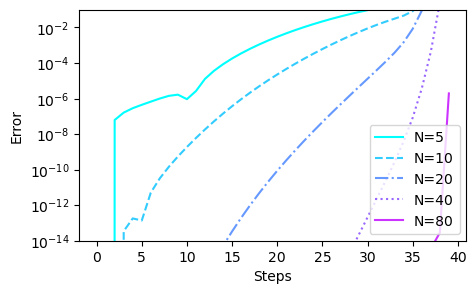

In [247]:
length = 40
parameter = 0
x_start = 10
plt.figure(figsize=(5,3))
for i, orders in enumerate([5,10,20,40,80]):
    error = np.abs(np.array(approx_trajectory[i])[: length, parameter] - np.array(ideal_trajectory)[: length, parameter])
    plt.plot(error, next(linecycler), label='N={}'.format(orders), color=cm.cool(0.2*i))
plt.legend()
plt.yscale('log')
plt.ylim(10**(-14),0.1)
plt.xlabel('Steps')
plt.ylabel('Error')
plt.savefig('error.svg')
plt.show()